# Practice querying MAST

Jack Dinsmore, June 2020

This notebook tests some of the methods I think I will apply to extract the lightcurves of individual stars neighboring one of the clusters we're measuring. It also includes some tools to access CDIPS, a project that calculated and saved lightcurves for many clusters that we could potentially check ours against.

I have not implemented some of the stuff I tested here, because all I did was add the CDIPS lightcurves and compare the sum to ours; I haven't done anything with `astroquery` yet.

In [1]:
%matplotlib inline
from astroquery.mast import Catalogs
from astropy.io import ascii
import numpy as np
from astropy.table import Table
import os
import lightkurve as lk
from math import *

import eleanor
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import pyplot as plt

CLUSTER = "NGC 6231"
LIGHTKURVE_CACHE = "/home/jtdinsmo/.lightkurve-cache/tesscut/"

COORDS = {"M34":(40.53083, 42.74615), "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 2391": (130.133, -53.033), 
          "NGC 6231":(253.53546, -41.82667), "Lambda Orionis":(83.784490, 9.934156), "NGC 3532":(166.44923, -58.7705),
          "Collinder 140":("111.113000", "-31.850000"),
          "Omega Cen": (201.69121, -47.47686), "47 Tuc": (6.022329, -72.081444), "NGC 6752": (287.71575, -59.98185)}

LOWER_LIMIT = 10
SCALE_FACTOR=1.5
IMAGE_SIZE = 180
IMAGE_SIZE_DEGREES = 1

POSTCARD_SIZE = 30

Error initializing plugin EntryPoint(name='Windows (alt)', value='keyrings.alt.Windows', group='keyring.backends').
Traceback (most recent call last):
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/keyring/backend.py", line 203, in _load_plugins
    init_func = ep.load()
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/importlib_metadata/__init__.py", line 105, in load
    module = import_module(match.group('module'))
  File "/usr/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_

In [2]:
if CLUSTER + ".dat" in os.listdir():
    brightData = Table.read(CLUSTER + ".dat", format="ascii")
else:
    catalogData = Catalogs.query_object(catalog="Tic",objectname=CLUSTER, radius="0.5 deg")
    brightData = catalogData[:]
    brightData = brightData[brightData["Tmag"] <= 13]
    ascii.write(brightData, CLUSTER + ".dat")
    
print(brightData[500:510])
print(len(brightData))
# Cluster coords: 253.53546, -41.82667

    ID            ra               dec        ... wdflag     dstArcSec    
---------- ---------------- ----------------- ... ------ -----------------
 246958135 253.402981678807 -42.0583512305516 ...      0 906.3579902643155
 339562550 253.484710783851  -41.577230313989 ...      0 908.2837310654012
1337603596 253.459548484799 -42.0726721722237 ...      0 908.6313007256764
 247263310  253.65280964896 -42.0637314124602 ...      0 909.4284771250958
 340417349 253.749484829561 -41.6308410030553 ...      0 909.7522380781639
 246958328 253.458680958894 -42.0728957094099 ...     -1 909.9375114498836
 246955723 253.247214715682 -41.9605030579403 ...      0 910.3778068109298
 340491401 253.865239769355 -41.8887145511522 ...      0 912.0110153152347
 339562721 253.415957470163 -41.5895180841493 ...      0 912.1586985844226
 338640230  253.20230259642 -41.7764372761558 ...      0 912.1817218455745
1428


For this test, we're going to only check out one star. The index of this star is set here:

In [79]:
i=1200
coords = SkyCoord(ra=brightData[i]["ra"], dec=brightData[i]["dec"], unit=(u.deg, u.deg))
#coords = SkyCoord(ra=COORDS[CLUSTER][0]-0.22, dec=COORDS[CLUSTER][1]+0.4, unit=(u.deg, u.deg))
print(coords)
# Cluster coords: 253.53546, -41.82667

<SkyCoord (ICRS): (ra, dec) in deg
    (252.95102748, -41.94644575)>


## Eleanor method (slow and bad)

With a little experimenting, I have come to the conclusion that I can't make `lightkurve` generate its own postcards for these stars, but I can make `eleanor` do it. So here's the code to download the `eleanor` postcard.

Aside from the issues with this method, it is nice because `eleanor` seems to use shorter exposure images, so that the stars are more resolved, which is important for our purposes.

In [80]:
star = eleanor.Source(coords=coords, tc=True)

Inflating...


And here's how to display it.

Set MJD-OBS to 58624.458010 from DATE-OBS.
Set MJD-END to 58652.374665 from DATE-END'. [astropy.wcs.wcs]
/home/jtdinsmo/.local/lib/python3.6/site-packages/eleanor/targetdata.py:300: UserWarning: We force our TPFs to have an odd height and width so we can properly center our apertures.
  warnings.warn('We force our TPFs to have an odd height and width so we can properly center our apertures.')
100%|██████████| 1289/1289 [03:43<00:00,  5.77it/s]


Text(0.5, 1.0, 'Target Pixel File')

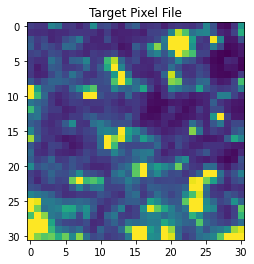

In [81]:
data = eleanor.TargetData(star, height=POSTCARD_SIZE, width=POSTCARD_SIZE, bkg_size=15, do_psf=True, do_pca=False)

fig, (ax1) = plt.subplots(ncols=1, figsize=(4, 4))
ax1.imshow(data.tpf[data.tpf.shape[0]//2], vmax = np.nanpercentile(data.tpf[data.tpf.shape[0]//2], 95))
ax1.set_title('Target Pixel File')

## Another, better method (fast and good, if it worked)

We could try to cut the TPF straight out of the FFI that we downloaded for the cluster. To do this, we need a function that maps (RA, dec) $\rightarrow$(x, y on FFI).

This function has been replaced by the one that Avi found, which works better than this one.

In [82]:
### This function is flawed. I will fix it.

def dot(u, v):
    return sum([u[i] * v[i] for i in range(len(u))])

def sub(u, v):
    return [u[i] - v[i] for i in range(len(u))]

def mul(u, s):
    if(type(u) != list):
        return [s[i] * u for i in range(len(s))]
    return [u[i] * s for i in range(len(u))]
    

def mag(v):
    return sqrt(dot(v, v))

def globalToImageCoords(ra, dec, centerRA, centerDec):
    ra = ra * pi / 180
    dec = dec * pi / 180
    centerRA = centerRA * pi / 180
    centerDec = centerDec * pi / 180
    
    target = [cos(ra) * cos(dec), sin(ra) * cos(dec), sin(dec)]
    imageCenter = [cos(centerRA) * cos(centerDec), sin(centerRA) * cos(centerDec), sin(centerDec)]
    target = mul(target, 1/dot(target, imageCenter))
    
    disp = sub(target, imageCenter)
    north = [-cos(centerRA) * sin(centerDec), -sin(centerRA) * sin(centerDec), cos(centerDec)]
    east = [sin(centerRA), -cos(centerRA), 0]
    angle = acos(dot(disp, north) / mag(north) / mag(disp))# Angle from north, measured towards east.
    if(dot(disp, east) < 0):
        angle = 2 * pi - angle
    
    length = acos(min(1, dot(target, imageCenter) / mag(imageCenter) / mag(target))) * 180 / pi# radians
    return [-int(length * IMAGE_SIZE / IMAGE_SIZE_DEGREES * sin(angle)) + IMAGE_SIZE // 2,
            int(length * IMAGE_SIZE / IMAGE_SIZE_DEGREES * cos(angle)) + IMAGE_SIZE // 2]
          
print(globalToImageCoords(coords.ra.value, coords.dec.value, COORDS[CLUSTER][0], COORDS[CLUSTER][1]))

[12, 69]


Here's the goal: what if we use the background subtraction that was generated when we made the cluster lightcurves, so that all we have to do is make an aperture for each star and take the star's lightcurve? To do that, we need to download the ffi for the whole cluster (actually, we just have to take it from the directory it is already stored in since it was downloaded using *cluster\_lightcurves.ipynb*)

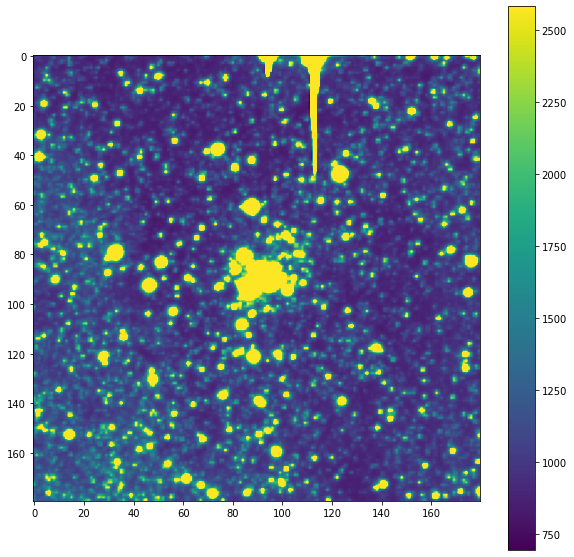

In [94]:


foundLocal = False
tpf = 0
for file in os.listdir(LIGHTKURVE_CACHE):
    if file.endswith("180x180_astrocut.fits"): # Confirm size
        if COORDS[CLUSTER][0] == float(file.split("_")[-4]): # Confirm RA
            if COORDS[CLUSTER][1] == float(file.split("_")[-3]): # Confirm dec
                tpf = lk.TessTargetPixelFile(LIGHTKURVE_CACHE + file)
                foundLocal = True
                break
if not foundLocal:
    raise Exception("This was supposed to be pre-downloaded :(")
    
    
avg_image = np.mean(tpf.flux, axis=0)
#avg_image = np.flip(avg_image, axis=1)# This was necessary for IC2391, not NGC 6231.

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
c = ax.imshow(avg_image, vmax = V_MAX)
plt.colorbar(c, ax=ax);

Now I need to make the masks for the cluster.

In [84]:
def countMaxima(data):
    stars = 0
    
    def getValue(x, y):
        if x < 0 or x >= data.shape[0] or y < 0 or y >= data.shape[0]:
            return 0 # Count this pixel as automatically smaller than everything else
        if np.isnan(data[x][y]):
            return 0 # Count this pixel as automatically smaller than everything else.
        if data[x][y] < LOWER_LIMIT:
            return 0 # Count this pixel as automatically smaller than everything else.
        return data[x][y]
        
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            b = data[x][y]
            if np.isnan(b): continue # Don't count nan pixels
            if b < LOWER_LIMIT: continue # Don't count pixels on edge of sector
            up = getValue(x, y-1)
            down = getValue(x, y+1)
            left = getValue(x-1, y)
            right = getValue(x+1, y)
            if b > max(up, down, left, right):
                stars += 1
    return stars

In [85]:
def getLimitMaximaMethod():
    numMaxima = countMaxima(avg_image)
    notNanMask = ~np.isnan(avg_image)
    notEdgeMask = avg_image > LOWER_LIMIT
    numPixels = np.count_nonzero(notNanMask & notEdgeMask) # Count the number of pixels that
        # are not nan and are greater than LOWER_LIMIT.
    n = 100 - SCALE_FACTOR * numMaxima / numPixels * 100
    return np.nanpercentile(avg_image, n)# Upper limit of the sky pixel flux range

In [86]:
upperLimit = getLimitMaximaMethod()
skyMask = ((avg_image >= LOWER_LIMIT) & # Exclude edge pixels
    (avg_image <= upperLimit)).reshape(180, 180).astype(bool)
starMask = ((avg_image > upperLimit)).reshape(180, 180).astype(bool)

The following method is not actually valid. I will have to remake the star mask, not simply cut it, because cutting it will include other, nearby stars.

In [87]:
cutoutCenter = globalToImageCoords(coords.ra.value, coords.dec.value, COORDS[CLUSTER][0], COORDS[CLUSTER][1])
cutoutRect = [cutoutCenter[0] - POSTCARD_SIZE // 2, cutoutCenter[1] - POSTCARD_SIZE // 2, 
              cutoutCenter[0] + POSTCARD_SIZE // 2, cutoutCenter[1] + POSTCARD_SIZE // 2]
print(cutoutRect)
cutoutRect[0] = max(cutoutRect[0], 0)
cutoutRect[1] = max(cutoutRect[1], 0)
cutoutRect[2] = min(cutoutRect[2], IMAGE_SIZE)
cutoutRect[3] = min(cutoutRect[3], IMAGE_SIZE)
smallStarMask = np.zeros_like(starMask)
for x in range(cutoutRect[0], cutoutRect[2]):
    for y in range(cutoutRect[1], cutoutRect[3]):
        smallStarMask = starMask[x][y]
        
smallStarMask = smallStarMask.astype(bool)

[-3, 54, 27, 84]


Drawing the cutout image:

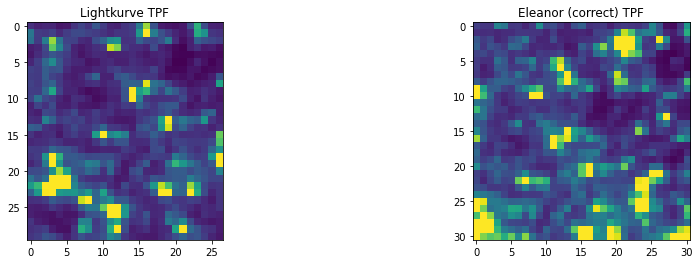

In [93]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4))
ax1.imshow(avg_image[cutoutRect[1]:cutoutRect[3],cutoutRect[0]:cutoutRect[2]], vmax = np.nanpercentile(avg_image, 95));
ax1.set_title("Lightkurve TPF");
#ax2.imshow(avg_image[cutoutRect[0]:cutoutRect[2],cutoutRect[1]:cutoutRect[3]], vmax = np.nanpercentile(avg_image, 95));
ax2.imshow(data.tpf[data.tpf.shape[0]//2], vmax = np.nanpercentile(data.tpf[data.tpf.shape[0]//2], 95));
ax2.set_title("Eleanor (correct) TPF");

# Questions:

For some reason, the location finder I made does not work perfectly agree with `eleanor` for NGC 6231. It's totally wrong for IC 2391. Here are some questions that could answer why.

- Does `lightkurve` automatically download FFIs with the north pole up?
- Does `eleanor` automatically center the coordinates in the middle of the TPF? (yes)
- Is my math wrong? (Then why does it work for NGC 6231?)